# 未観測共通原因

## 準備

### インポート

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# warningsを非表示（任意）
warnings.filterwarnings('ignore')

# numpyは小数第3位まで表示
np.set_printoptions(precision=3, suppress=True)

# 乱数を設定
np.random.seed(10)

### ユーティリティ

In [2]:
# 入力した事前知識に対応する因果構造を描画する関数
# https://lingam.readthedocs.io/en/latest/tutorial/pk_bottom_up_parce.html

def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')

    labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

### テストデータ

In [3]:
# 各変数ごとにデータ生成
x6 = np.random.uniform(size=1000)
x3 = 2.0*x6 + np.random.uniform(size=1000)
x0 = 0.5*x3 + np.random.uniform(size=1000)
x2 = 2.0*x6 + np.random.uniform(size=1000)
x1 = 0.5*x0 + 0.5*x2 + np.random.uniform(size=1000)
x5 = 0.5*x0 + np.random.uniform(size=1000)
x4 = 0.5*x0 - 0.5*x2 + np.random.uniform(size=1000)

# DataFrameとして格納（ただしx6は未観測共通原因とするため含めない）
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T, columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

$$
\begin{align*}
x_6&=e_6\\
x_3&=2x_6+e_3\\
x_0&=0.5x_3+e_0\\
x_2&=2x_6+e_2\\
x_1&=0.5x_0+0.5x_2+e_1\\
x_5&=0.5x_0+e_5\\
x_4&=0.5x_0-0.5x_2+e_4
\end{align*}
$$

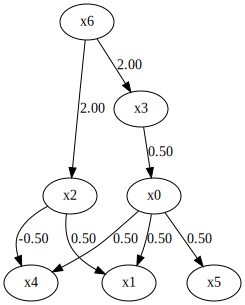

In [4]:
# 線形方程式の係数（因果効果）を行列で表現
m = np.array([[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0],
              [0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0],
              [0.5, 0.0,-0.5, 0.0, 0.0, 0.0, 0.0],
              [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

# グラフの作成
dot = lingam.utils.make_dot(m)

# pdf形式で保存
dot.render('Hidden_Common_Causes_dag')

# png形式で保存
dot.format = 'png'
dot.render('Hidden_Common_Causes_dag')

# グラフの描写
dot

## Direct LiNGAM を用いた場合

### 因果探索

In [5]:
# Direct LiNGAM のオブジェクト
model = lingam.DirectLiNGAM()

# 学習
model.fit(X)

In [6]:
# （推定）因果的順序の表示
model.causal_order_

[3, 0, 2, 4, 1, 5]

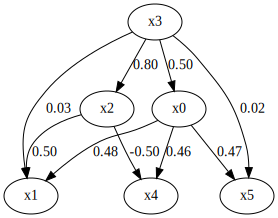

In [7]:
# グラフの作成
dot = lingam.utils.make_dot(model.adjacency_matrix_)

# pdf形式で保存
dot.render('Direct_LiNGAM_pred_dag')

# png形式で保存
dot.format = 'png'
dot.render('Direct_LiNGAM_pred_dag')

# グラフの描写
dot

### 残差間の独立性検定

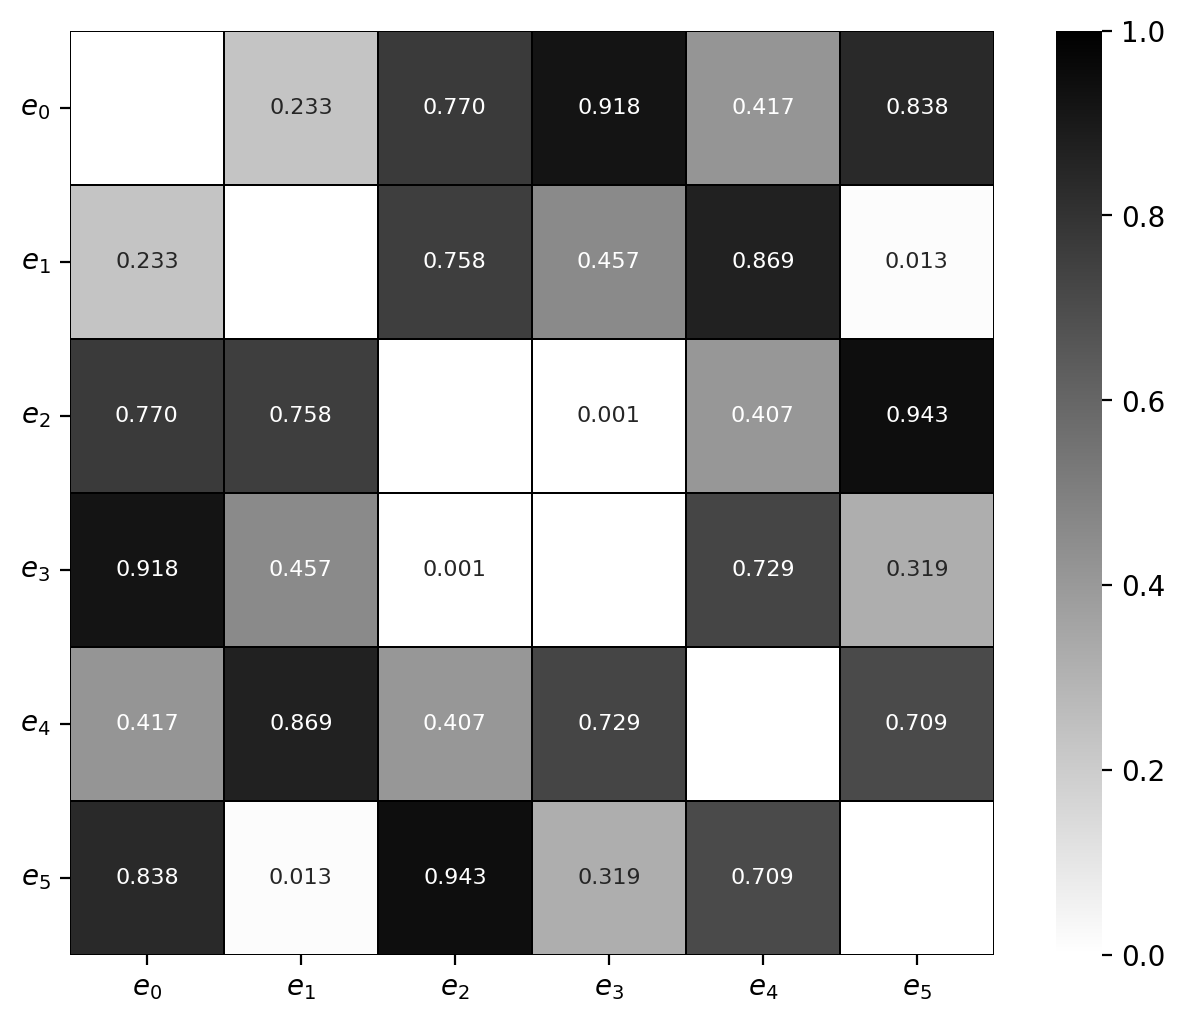

In [8]:
# 変数の合計数を計算（x6は抜いて今回は計6個）
P = X.shape[1]

# 独立性検定のp値を計算
p_values = model.get_error_independence_p_values(X)

# 対角成分は考慮すべきでないため取り除く
p_values_nan = p_values + np.diag(np.ones(P)*np.nan)

# ヒートマップとして可視化
plt.figure(figsize=[8,6], dpi=200)
sns.heatmap(p_values_nan, square=True, cmap='binary', linewidths=.05, linecolor='k', vmin=0.0, vmax=1.0, annot=True, fmt="1.3f", annot_kws={'fontsize':8})
ticks_label = [fr'$e_{{{i}}}$' for i in range(P)]
plt.xticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.yticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.savefig('Pvalues_DirectLiNGAM.png')

## BottomUpParceLiNGAM

### 因果探索

In [9]:
# BottomUpParceLiNGAM のオブジェクト
model = lingam.BottomUpParceLiNGAM()

# 学習
model.fit(X)

In [10]:
# （推定）因果的順序の表示
model.causal_order_

[[2, 3], 0, 4, 5, 1]

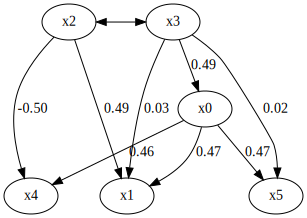

In [11]:
# グラフの作成
dot = lingam.utils.make_dot(model.adjacency_matrix_)

# pdf形式で保存
dot.render('Bottom_Up_Parce_LiNGAM_pred_dag')

# png形式で保存
dot.format = 'png'
dot.render('Bottom_Up_Parce_LiNGAM_pred_dag')

# グラフの描写
dot

### 残差間の独立性検定

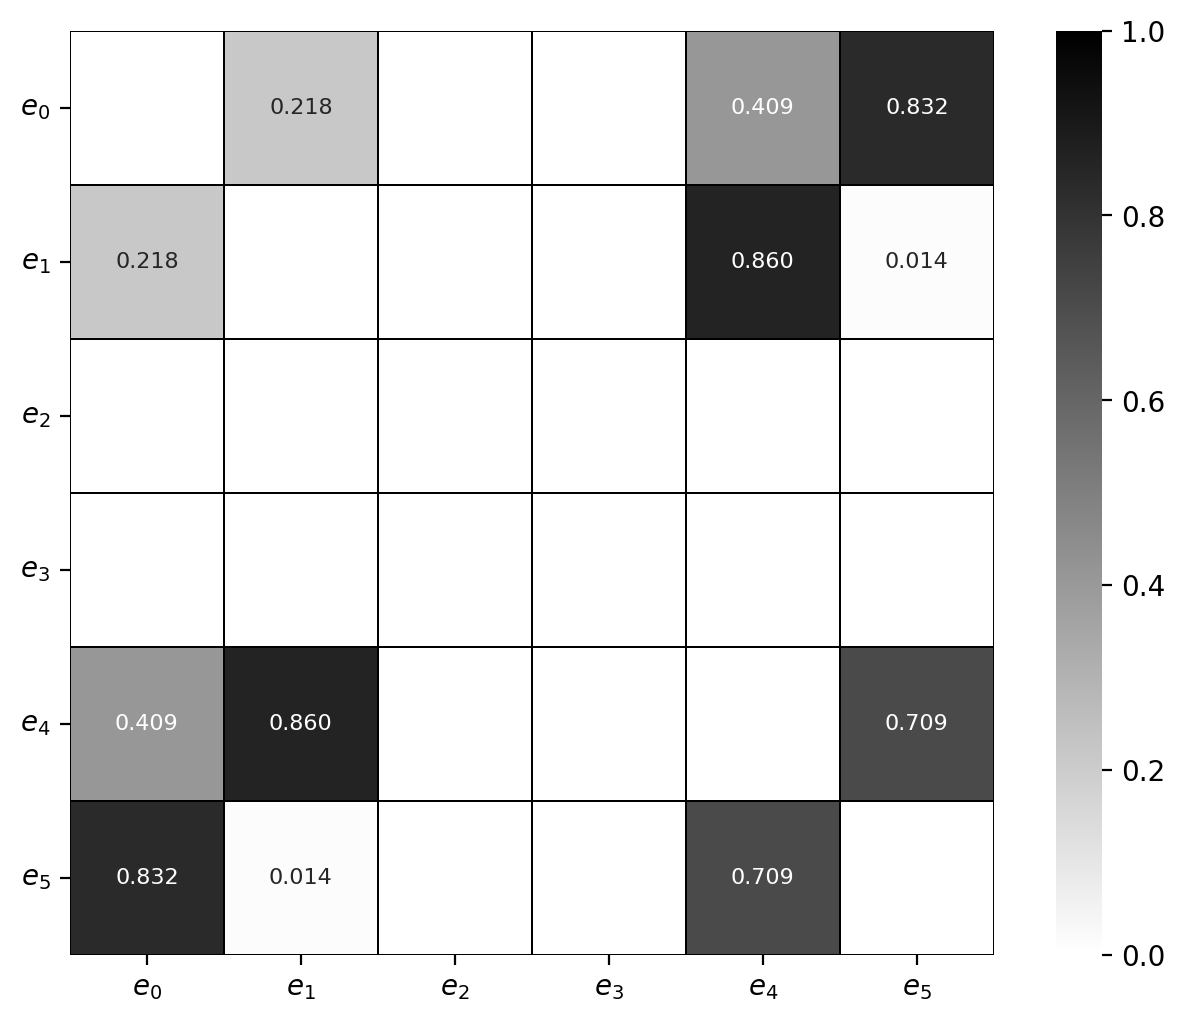

In [12]:
# 変数の合計数を計算（x6は抜いて今回は計6個）
P = X.shape[1]

# 独立性検定のp値を計算
p_values = model.get_error_independence_p_values(X)

# 対角成分は考慮すべきでないため取り除く
p_values_nan = p_values + np.diag(np.ones(P)*np.nan)

# ヒートマップとして可視化
plt.figure(figsize=[8,6], dpi=200)
sns.heatmap(p_values_nan, square=True, cmap='binary', linewidths=.05, linecolor='k', vmin=0.0, vmax=1.0, annot=True, fmt="1.3f", annot_kws={'fontsize':8})
ticks_label = [fr'$e_{{{i}}}$' for i in range(P)]
plt.xticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.yticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.savefig('Pvalues_Bottom_Up_Parce_LiNGAM.png')

### ブートストラップ法

In [13]:
# BottomUpParceLiNGAM のオブジェクト
model = lingam.BottomUpParceLiNGAM()

# ブートストラップ法（サンプリング数100）で学習
result = model.bootstrap(X, n_sampling=100)

### 因果方向

In [14]:
# ブートストラップ法の結果に基づき因果の矢印を確度の高い順で集計
# n_directions: 集計する因果の矢印の数（ランキング順）
# min_causal_effect: 集計する係数（因果効果）の最小値
# split_by_causal_effect_sign: 係数（因果効果）の符号を区別するかどうか
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)

In [15]:
# 集計結果の表示
# 第2引数（=100）はブートストラップ法のサンプリング数を入力
lingam.utils.print_causal_directions(cdc, 100)

x1 <--- x2 (b>0) (46.0%)
x1 <--- x0 (b>0) (45.0%)
x4 <--- x2 (b<0) (36.0%)
x4 <--- x0 (b>0) (36.0%)
x1 <--- x3 (b>0) (33.0%)
x5 <--- x0 (b>0) (33.0%)
x5 <--- x3 (b>0) (20.0%)
x4 <--- x5 (b>0) (17.0%)


### 有向非巡回グラフ

In [16]:
# ブートストラップ法の結果に基づき因果構造を確度の高い順で集計
# n_dags: 集計する因果構造の数（ランキング順）
# min_causal_effect: 考慮する係数（因果効果）の最小値
# split_by_causal_effect_sign: 係数（因果効果）の符号を区別するかどうか
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)

In [17]:
# 集計結果の表示
# 第2引数（=100）はブートストラップサンプル数を入力
lingam.utils.print_dagc(dagc, 100)

DAG[0]: 30.0%
DAG[1]: 8.0%
	x1 <--- x0 (b>0)
	x1 <--- x2 (b>0)
	x1 <--- x3 (b>0)
DAG[2]: 4.0%
	x4 <--- x0 (b>0)
	x4 <--- x2 (b<0)
	x4 <--- x5 (b>0)


### 出現確率

In [18]:
# ブートストラップ法の結果に基づき各因果の矢印の出現確率を集計
# min_causal_effect: 考慮する係数（因果効果）の最小値
prob = result.get_probabilities(min_causal_effect=0.01)

# 集計結果の表示
print(prob)

[[0.   0.01 0.02 0.08 0.   0.  ]
 [0.45 0.   0.46 0.33 0.03 0.14]
 [0.08 0.08 0.   0.08 0.   0.06]
 [0.   0.   0.   0.   0.   0.  ]
 [0.36 0.02 0.36 0.02 0.   0.17]
 [0.33 0.04 0.09 0.2  0.02 0.  ]]


### （総合）因果効果

In [19]:
# ブートストラップ法の結果に基づき（総合）因果効果を計算
# min_causal_effect: 考慮する係数（因果効果）の最小値
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

# DataFrameに結果をまとめる
df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])

In [20]:
# （総合）因果効果の大きい順にトップ5を表示
print(df.sort_values('effect', ascending=False).head())

  from  to    effect  probability
0   x0  x4  0.497888         0.08
2   x0  x5  0.486412         0.08
3   x0  x1  0.464910         0.07
4   x1  x0  0.421073         0.01
6   x1  x4  0.207603         0.01


In [21]:
# 存在確率の小さい順にトップ5を表示
print(df.sort_values('probability', ascending=True).head())

  from  to    effect  probability
4   x1  x0  0.421073         0.01
5   x5  x2  0.057454         0.01
6   x1  x4  0.207603         0.01
7   x5  x4  0.017990         0.01
8   x1  x5  0.103649         0.01


In [22]:
# x1に向かう（総合）因果効果を表示
print(df[df['to']=='x1'].head())

  from  to   effect  probability
3   x0  x1  0.46491         0.07


### 経路の存在確率と（総合）因果効果

In [23]:
# ブートストラップ法の結果に基づき経路の存在確率と（総合）因果効果を計算
from_index = 3 # 原因となる変数のインデックス（x3）
to_index = 1 # 結果となる変数のインデックス（x1）

# 存在確率の大きい順にトップ5を表示
print(pd.DataFrame(result.get_paths(from_index, to_index)).head())

           path    effect  probability
0        [3, 1]  0.043051         0.39
1     [3, 0, 1]  0.244008         0.07
2  [3, 0, 5, 1] -0.021364         0.02
3     [3, 5, 1] -0.001489         0.01


## Bottom Up Parce LiNGAM（事前知識あり）

### 事前知識を表現する隣接行列（パターン①）

In [24]:
# 事前知識を表現する隣接行列を計算
# ここでは6変数でインデックスが[0,1,4]（=x0,x1,x4）が因果構造の葉であることを既知としている
prior_knowledge = lingam.utils.make_prior_knowledge(
    n_variables=6,
    sink_variables=[0, 1, 4],
)

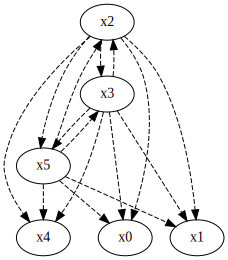

In [25]:
# 事前知識を踏まえた取りうる因果構造を描写
make_prior_knowledge_graph(prior_knowledge)

### 因果探索（パターン①）

In [26]:
# BottomUpParceLiNGAMのオブジェクト（事前知識を入力）
model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)

# 学習
model.fit(X)

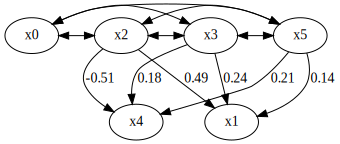

In [27]:
# 事前知識を入力したBottomUpParceLiNGAMの推定結果を表示
lingam.utils.make_dot(model.adjacency_matrix_)

### 事前知識を表現する隣接行列（パターン②）

In [28]:
# 事前知識を表現する隣接行列を計算
# ここでは6変数でインデックスが[0]（=x0）が因果構造の根であることを既知としている
prior_knowledge = lingam.utils.make_prior_knowledge(
    n_variables=6,
    exogenous_variables=[0],
)

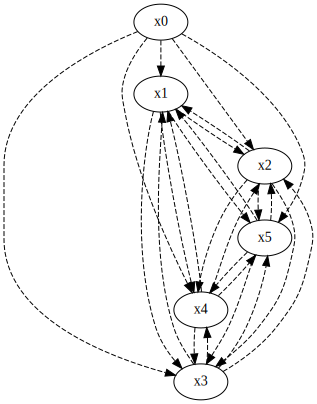

In [29]:
# 事前知識を踏まえた取りうる因果構造を描写
make_prior_knowledge_graph(prior_knowledge)

### 因果探索（パターン②）

In [30]:
# BottomUpParceLiNGAMのオブジェクト（事前知識を入力）
model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)

# 学習
model.fit(X)

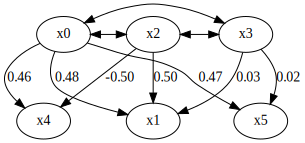

In [31]:
# 事前知識を入力したBottomUpParceLiNGAMの推定結果を表示
lingam.utils.make_dot(model.adjacency_matrix_)

### 事前知識を表現する隣接行列（パターン③）

In [32]:
# 事前知識を表現する隣接行列を計算
# ここでは葉と根に関する正しい情報を入力している
prior_knowledge = lingam.utils.make_prior_knowledge(
    n_variables=6,
    sink_variables=[1, 4, 5],
    exogenous_variables=[2,3],
)

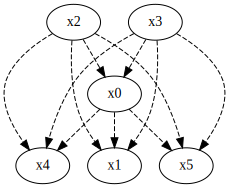

In [33]:
# 事前知識を踏まえた取りうる因果構造を描写
make_prior_knowledge_graph(prior_knowledge)

### 因果探索（パターン③）

In [34]:
# BottomUpParceLiNGAMのオブジェクト（事前知識を入力）
model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)

# 学習
model.fit(X)

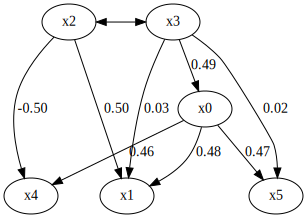

In [35]:
# 事前知識を入力したBottomUpParceLiNGAMの推定結果を表示
lingam.utils.make_dot(model.adjacency_matrix_)

## RCD　(Repetitive Causal Discovery)

In [36]:
# RCDのオブジェクト
model = lingam.RCD()

# 学習
model.fit(X)

In [37]:
# 各変数ごとの推定された親を表示
ancestors_list = model.ancestors_list_

for i, ancestors in enumerate(ancestors_list):
    parents = ', '.join([f'x{j}' for j in ancestors])
    print(f"pa(x{i})=" + "{" + f"{parents}" + "}")

pa(x0)={x2, x3}
pa(x1)={x0, x2, x3}
pa(x2)={}
pa(x3)={}
pa(x4)={x0, x2, x3}
pa(x5)={x0, x1, x2, x3}


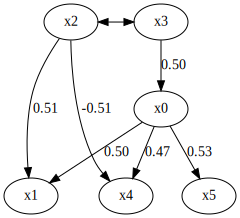

In [38]:
# グラフの作成
dot = lingam.utils.make_dot(model.adjacency_matrix_)

# pdf形式で保存
dot.render('RCD_pred_dag')

# png形式で保存
dot.format = 'png'
dot.render('RCD_pred_dag')

# グラフの描写
dot

### 残差間の独立性検定

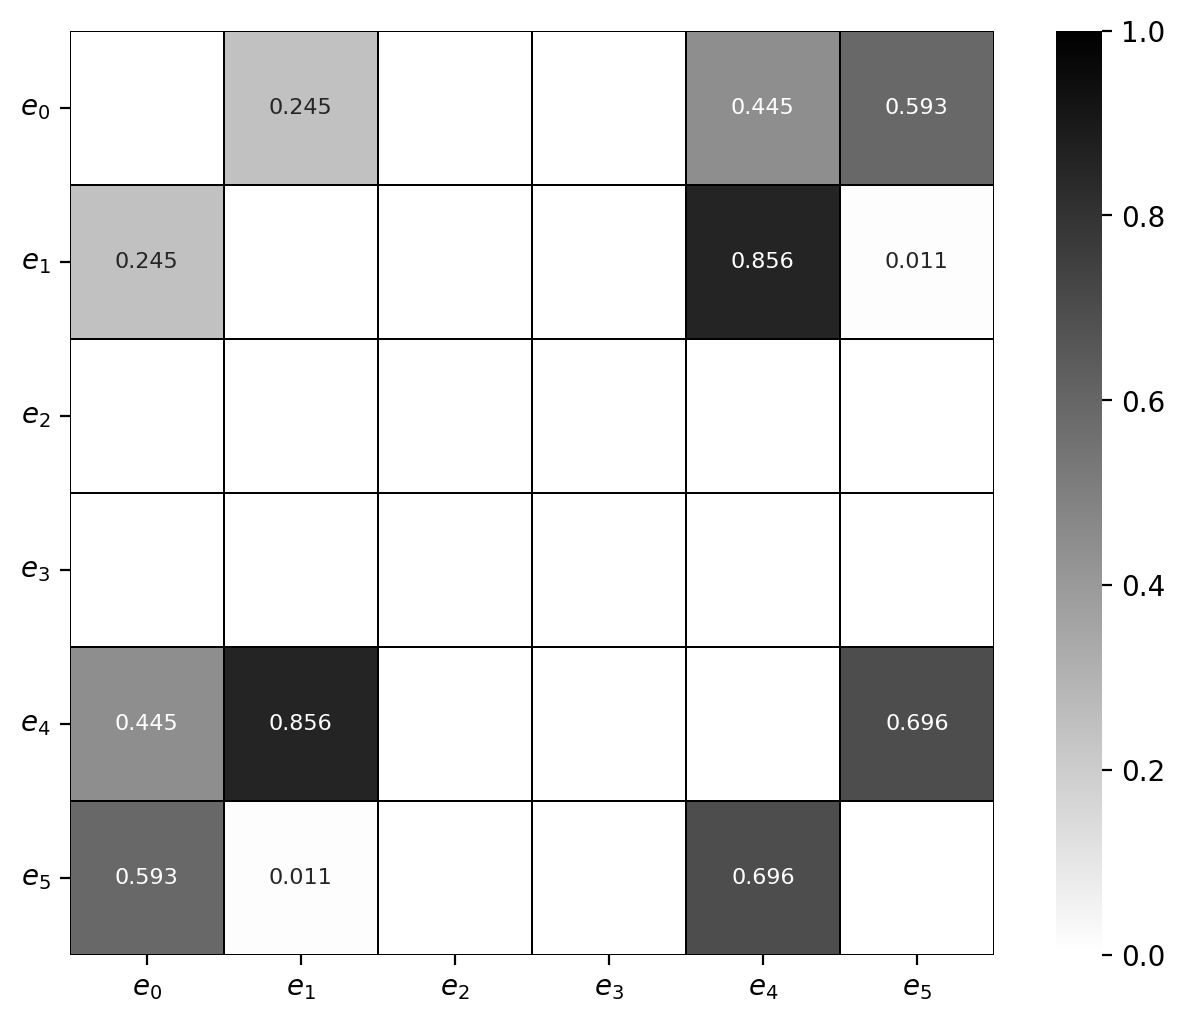

In [39]:
# 変数の合計数を計算（x6は抜いて今回は計6個）
P = X.shape[1]

# 独立性検定のp値を計算
p_values = model.get_error_independence_p_values(X)

# 対角成分は考慮すべきでないため取り除く
p_values_nan = p_values + np.diag(np.ones(P)*np.nan)

# ヒートマップとして可視化
plt.figure(figsize=[8,6], dpi=200)
sns.heatmap(p_values_nan, square=True, cmap='binary', linewidths=.05, linecolor='k', vmin=0.0, vmax=1.0, annot=True, fmt="1.3f", annot_kws={'fontsize':8})
ticks_label = [fr'$e_{{{i}}}$' for i in range(P)]
plt.xticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.yticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.savefig('Pvalues_RCD.png')

### ブートストラップ法

In [40]:
# RCDのオブジェクト
model = lingam.RCD()

# ブートストラップ法（サンプリング数100）で学習
result = model.bootstrap(X, n_sampling=100)

### 因果方向

In [41]:
# ブートストラップ法の結果に基づき因果の矢印を確度の高い順で集計
# n_directions: 集計する因果の矢印の数（ランキング順）
# min_causal_effect: 集計する係数（因果効果）の最小値
# split_by_causal_effect_sign: 係数（因果効果）の符号を区別するかどうか
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)

In [42]:
# 集計結果の表示
# 第2引数（=100）はブートストラップ法のサンプリング数を入力
lingam.utils.print_causal_directions(cdc, 100)

x1 <--- x2 (b>0) (99.0%)
x0 <--- x3 (b>0) (94.0%)
x5 <--- x0 (b>0) (94.0%)
x1 <--- x0 (b>0) (93.0%)
x4 <--- x2 (b<0) (93.0%)
x4 <--- x0 (b>0) (87.0%)
x2 <--- x3 (b>0) (24.0%)
x1 <--- x3 (b>0) (6.0%)


### 有向非巡回グラフ

In [43]:
# ブートストラップ法の結果に基づき因果構造を確度の高い順で集計
# n_dags: 集計する因果構造の数（ランキング順）
# min_causal_effect: 考慮する係数（因果効果）の最小値
# split_by_causal_effect_sign: 係数（因果効果）の符号を区別するかどうか
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)

In [44]:
# 集計結果の表示
# 第2引数（=100）はブートストラップサンプル数を入力
lingam.utils.print_dagc(dagc, 100)

DAG[0]: 62.0%
	x0 <--- x3 (b>0)
	x1 <--- x0 (b>0)
	x1 <--- x2 (b>0)
	x4 <--- x0 (b>0)
	x4 <--- x2 (b<0)
	x5 <--- x0 (b>0)
DAG[1]: 21.0%
	x0 <--- x3 (b>0)
	x1 <--- x0 (b>0)
	x1 <--- x2 (b>0)
	x2 <--- x3 (b>0)
	x4 <--- x0 (b>0)
	x4 <--- x2 (b<0)
	x5 <--- x0 (b>0)
DAG[2]: 5.0%
	x0 <--- x3 (b>0)
	x1 <--- x0 (b>0)
	x1 <--- x2 (b>0)
	x5 <--- x0 (b>0)


### 出現確率

In [45]:
# ブートストラップ法の結果に基づき各因果の矢印の出現確率を集計
# min_causal_effect: 考慮する係数（因果効果）の最小値
prob = result.get_probabilities(min_causal_effect=0.01)

# 集計結果の表示
print(prob)

[[0.   0.   0.   0.94 0.   0.  ]
 [0.93 0.   0.99 0.06 0.   0.  ]
 [0.   0.   0.   0.24 0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.87 0.   0.93 0.06 0.   0.  ]
 [0.94 0.08 0.   0.05 0.   0.  ]]


### （総合）因果効果

In [46]:
# ブートストラップ法の結果に基づき（総合）因果効果を計算
# min_causal_effect: 考慮する係数（因果効果）の最小値
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

# DataFrameに結果をまとめる
df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])

In [47]:
# （総合）因果効果の大きい順にトップ5を表示
print(df.sort_values('effect', ascending=False).head())

  from  to    effect  probability
7   x3  x2  0.805103         0.21
6   x3  x1  0.671553         0.21
1   x0  x4  0.497888         0.86
5   x3  x0  0.496532         0.21
2   x0  x5  0.486412         0.86


In [48]:
# 存在確率の小さい順にトップ5を表示
print(df.sort_values('probability', ascending=True).head())

  from  to    effect  probability
5   x3  x0  0.496532         0.21
6   x3  x1  0.671553         0.21
7   x3  x2  0.805103         0.21
8   x3  x4 -0.179697         0.21
9   x3  x5  0.278913         0.21


In [49]:
# x1に向かう（総合）因果効果を表示
print(df[df['to']=='x1'].head())

  from  to    effect  probability
0   x0  x1  0.464910         0.86
3   x2  x1  0.485362         0.22
6   x3  x1  0.671553         0.21


### 経路の存在確率と（総合）因果効果

In [50]:
# ブートストラップ法の結果に基づき経路の存在確率と（総合）因果効果を計算
from_index = 3 # 原因となる変数のインデックス（x3）
to_index = 1 # 結果となる変数のインデックス（x1）

# 存在確率の大きい順にトップ5を表示
print(pd.DataFrame(result.get_paths(from_index, to_index)).head())

        path    effect  probability
0  [3, 0, 1]  0.249388         0.93
1  [3, 2, 1]  0.412098         0.24
2     [3, 1]  0.281594         0.06
